In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import mode
import scipy as sp

import bambi
import pymc3 as pm
import arviz as az

from seaborn import despine
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('paper')
sns.set_style("ticks")

from utils.plotting import cm2inch, violin
from utils.stats import get_var
from utils.general import make_sure_path_exists

# Descriptives

In [2]:
# directories
data_dir = '../data/'
mfx_dir = '../results/posterior_traces/mixed_effects_models/'
figure_dir = '../figures/'
results_dir = '../results/'

# make sure output dirs exist
make_sure_path_exists(figure_dir)
make_sure_path_exists(mfx_dir)

# set sizes and subjects
setsizes = np.array([9, 16, 25, 36])
n_setsizes = setsizes.size
subjects = np.arange(49)
n_subjects = subjects.size

# indicators for each set sizes
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']
markers = ['o', '^', 's', 'D']

# model specifications
model_names = ['probabilistic_satisficing', 'independent_accumulation', 'GLAM']
model_names_short = ['PSM', 'IAM', 'GLAM']
gaze_bias_states = ['with_active_gaze', 'with_passive_gaze']

### Test convergence of individual models

In [3]:
for setsize in setsizes:
    for subject in subjects:
        for model_name in model_names:
            for gaze_bias in gaze_bias_states:
                
                # load trace summary
                filepath = results_dir+'posterior_traces/{}_{}/{}_{}_mtrace_summary.csv'.format(
                        model_name, gaze_bias, subject, setsize)
                if os.path.isfile(filepath):
                    # load trace summary
                    trace_summary = pd.read_csv(filepath)
                    # check for convergence according to effecting sample mean & gelman statistic
                    enough_eff = np.all(trace_summary['ess_mean'].values > 100)
                    good_gelman = np.all([np.abs(R-1) < 0.05 for R in trace_summary['r_hat'].values if not np.isnan(R)])
                    if not enough_eff or not good_gelman:
                        print('{}_{}: not converged for subject {} in set size {}'.format(model_name, gaze_bias, subject, setsize))
                        
                else:
                    print('/!\ no trace summary for {}_{} subject {} in set size {}'.format(
                        model_name, gaze_bias, subject, setsize))
                
                # check if trace file exists also
                filepath = results_dir+'posterior_traces/{}_{}/{}_{}_mtrace.csv'.format(
                    model_name, gaze_bias, subject, setsize)
                if not os.path.isfile(filepath):
                    print('/!\ no trace data for {}_{} subject {} in set size {}'.format(
                        model_name, gaze_bias, subject, setsize))

independent_accumulation_with_active_gaze: not converged for subject 12 in set size 9
independent_accumulation_with_active_gaze: not converged for subject 39 in set size 9
independent_accumulation_with_active_gaze: not converged for subject 42 in set size 9
independent_accumulation_with_active_gaze: not converged for subject 12 in set size 16
independent_accumulation_with_active_gaze: not converged for subject 17 in set size 25


# Figure 5


9-items: Computing WAIC(PSM+) vs. WAIC(IAM+):
U = 1592.0, p = 0.005467151392757174

9-items: Computing WAIC(PSM+) vs. WAIC(GLAM+):
U = 1287.0, p = 0.5411677383995455

9-items: Computing WAIC(GLAM+) vs. WAIC(IAM+):
U = 1518.0, p = 0.024300054686674934

16-items: Computing WAIC(PSM+) vs. WAIC(IAM+):
U = 1705.0, p = 0.00034224750484806044

16-items: Computing WAIC(PSM+) vs. WAIC(GLAM+):
U = 1444.0, p = 0.08424561162157408

16-items: Computing WAIC(GLAM+) vs. WAIC(IAM+):
U = 1507.0, p = 0.029690539004809995

25-items: Computing WAIC(PSM+) vs. WAIC(IAM+):
U = 1573.0, p = 0.008214147937694476

25-items: Computing WAIC(PSM+) vs. WAIC(GLAM+):
U = 1460.0, p = 0.06573161487231483

25-items: Computing WAIC(GLAM+) vs. WAIC(IAM+):
U = 1388.0, p = 0.18395542965270695

36-items: Computing WAIC(PSM+) vs. WAIC(IAM+):
U = 1508.0, p = 0.029161263458871538

36-items: Computing WAIC(PSM+) vs. WAIC(GLAM+):
U = 1469.0, p = 0.05688461043705417

36-items: Computing WAIC(GLAM+) vs. WAIC(IAM+):
U = 1289.0, p = 

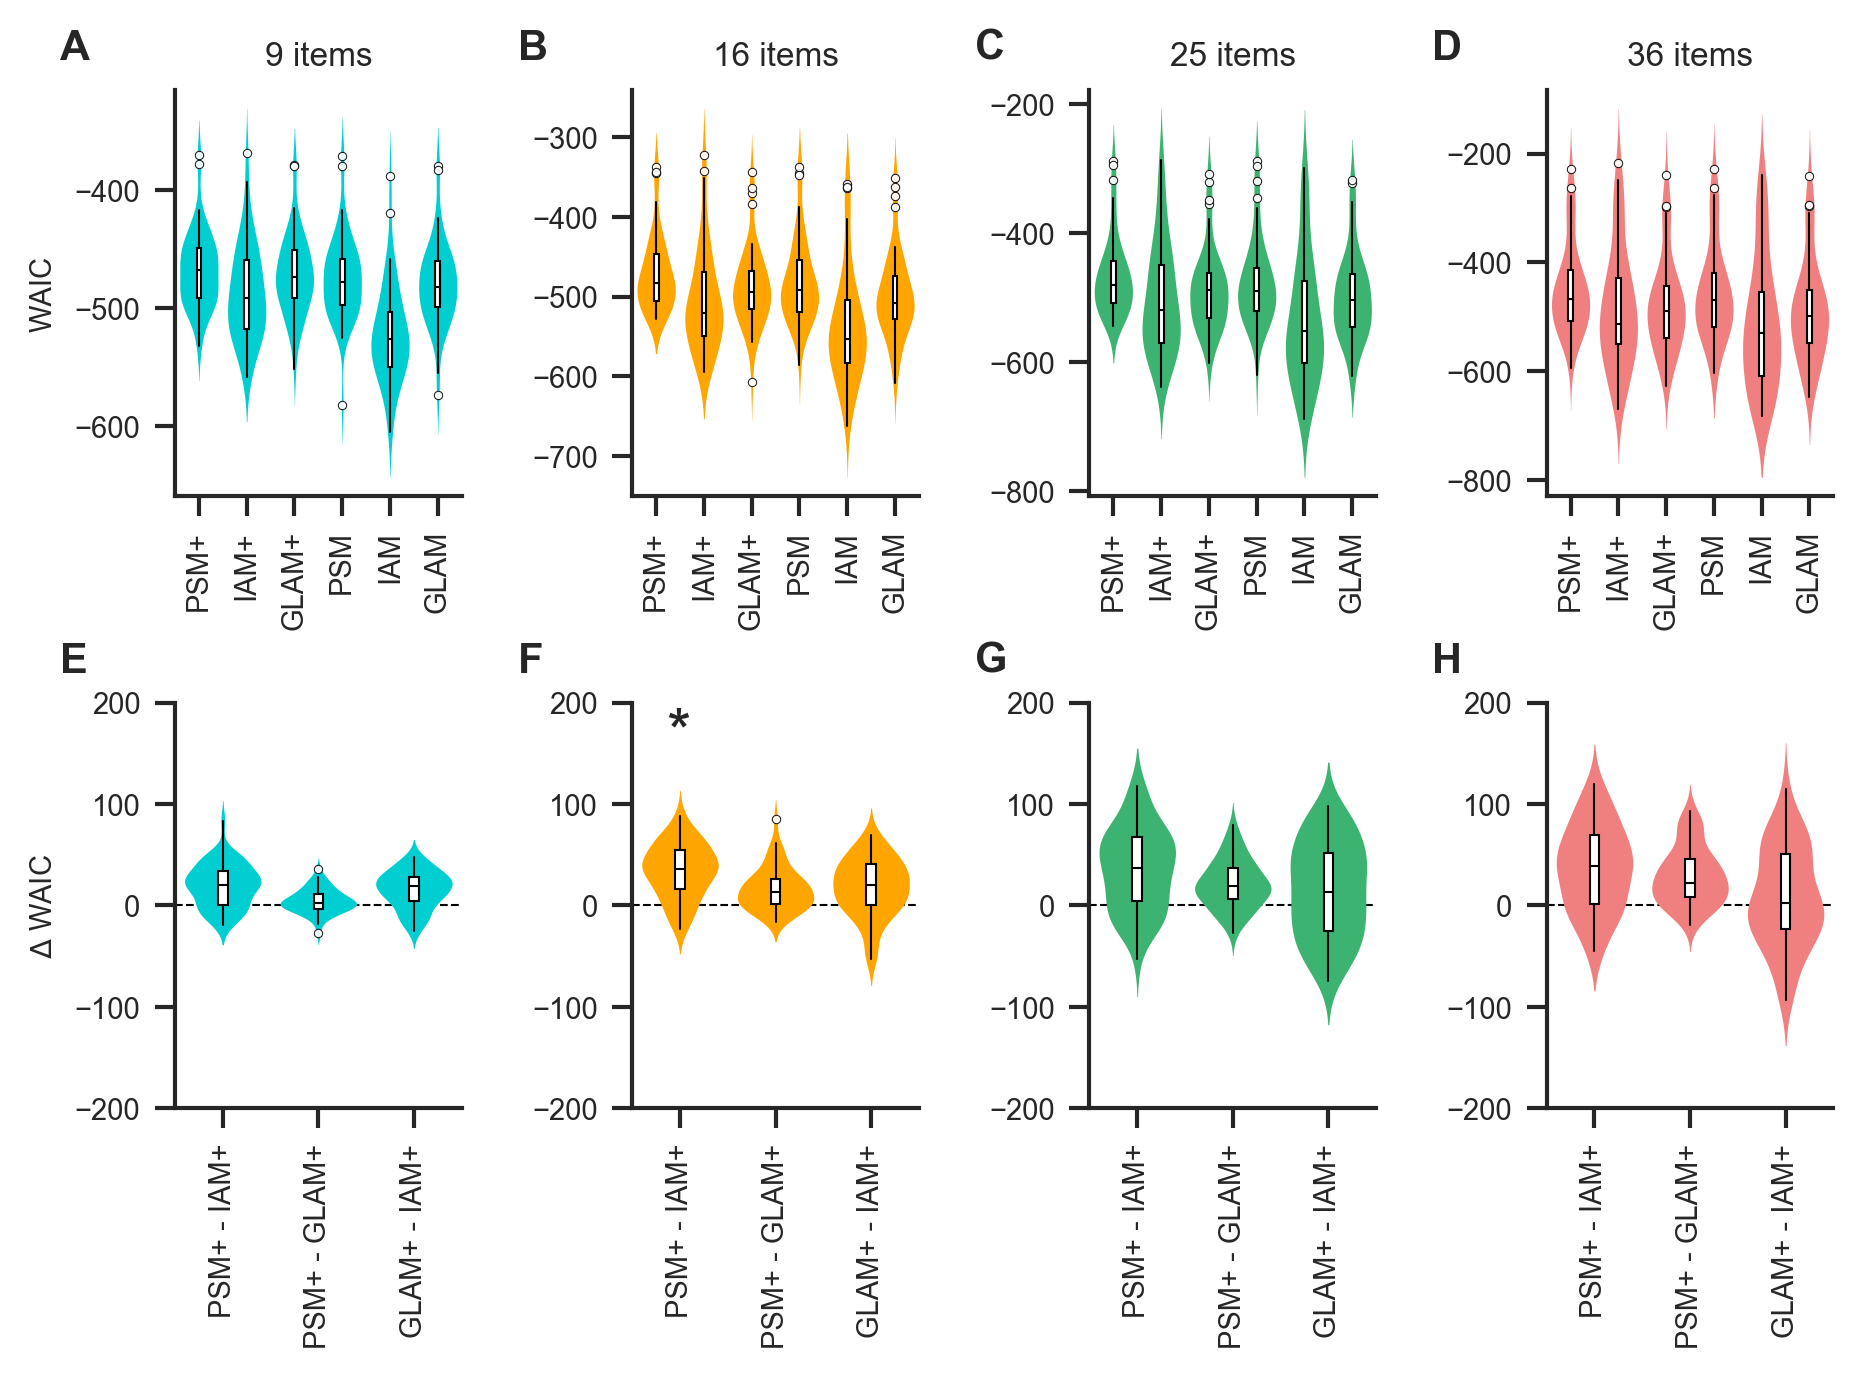

In [4]:
fig, axs = plt.subplots(2,4,figsize=cm2inch(16,12), dpi=300)

WAIC = np.zeros((setsizes.size, subjects.size, len(model_names)*len(gaze_bias_states))) * np.nan
for si, setsize in enumerate(setsizes):
    for subject in subjects:
        mi = 0
        for gaze_bias in gaze_bias_states:
            for model_name in model_names:
                filepath = results_dir+'waic/{}_{}/{}_{}_waic.csv'.format(model_name, gaze_bias, subject, setsize)
                if os.path.isfile(filepath):
                    waic = pd.read_csv(filepath)
                    WAIC[si,subject,mi] = waic['WAIC'].values[0]
                else:
                    WAIC[si,subject,mi] = np.nan
                mi += 1
        
    # plot violin
    axs[0,si] = violin(data=pd.DataFrame(WAIC[si]), ax=axs[0,si], palette=[colors[si]]*WAIC.shape[-1])
    axs[0,si].set_title('{} items'.format(setsize), fontsize=8)
    axs[0,si].set_xticks(np.arange(6))
    axs[0,si].set_xticklabels(['PSM+', 'IAM+', 'GLAM+', 'PSM', 'IAM', 'GLAM'], fontsize=7, rotation=90)
    axs[0,si].tick_params(labelsize=7)
    axs[0,si].set_xlabel('', fontsize=7)
    if si == 0:
        axs[0,si].set_ylabel('WAIC', fontsize=7)
    else:
        axs[0,si].set_ylabel('')
    
    # plot WAIC differences:
    axs[1,si].axhline(0, lw=0.5, ls='--', color='k', zorder=-99)
    waic_differences = pd.DataFrame({'1':WAIC[si,:,0]-WAIC[si,:,1], # PSM+ vs IAM+ 
                                     '2':WAIC[si,:,0]-WAIC[si,:,2],  # PSM+ vs GLAM+ 
                                     '3':WAIC[si,:,2]-WAIC[si,:,1]}) # GLAM+ vs IAM+
    axs[1,si] = violin(data=waic_differences, ax=axs[1,si], palette=[colors[si]]*3)
    
    # plotting settings
    if si == 0:
        axs[1,si].set_ylabel(r'$\Delta$'+' WAIC', fontsize=7)
    else:
        axs[1,si].set_ylabel('')
    axs[1,si].set_xlabel('')
    axs[1,si].set_xticks(np.arange(3))
    axs[1,si].set_ylim(-200,200)
    axs[1,si].set_xticklabels(['PSM+ - IAM+',
                               'PSM+ - GLAM+',
                               'GLAM+ - IAM+'],
                              fontsize=7, rotation=90)
    axs[1,si].tick_params(labelsize=7)  
    
    # test if WAIC distributions meaningfully different:
    for mi, (mA, mB) in enumerate(zip([0,0,2], [1,2,1])):    
        print('\n{}-items: Computing WAIC({}+) vs. WAIC({}+):'.format(setsize, model_names_short[mA], model_names_short[mB]))
        # compare whether WAIC value distributions different:
        U, p = sp.stats.mannwhitneyu(WAIC[si,:,mA], WAIC[si,:,mB], alternative='two-sided')
        print('U = {}, p = {}'.format(U, p))
        # add marker if difference is statistically meaningful
        if np.float(p) < (0.05/12.):
            axs[1,si].text(mi-0.15, 150, '*', fontsize=15) 
            

for label, ax in zip(list('ABCDEFGH'), axs.ravel()):
    despine(ax=ax)
    ax.text(-0.4, 1.15, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')

fig.tight_layout(h_pad=0)
fig.savefig(figure_dir+'Figure-5_relative-fit.pdf',dpi=300)
fig.savefig(figure_dir+'Figure-5_relative-fit.jpg',dpi=300)
fig.savefig(figure_dir+'Figure-5_relative-fit.png',dpi=300)

## Count number of subjects best described by each model:

In [5]:
for si, setsize in enumerate(setsizes):
    print('\nSet size: {}'.format(setsize))
    print('{} ({:1.2f}%) best described by models with active gaze'.format(
                np.sum(np.argmax(WAIC[si], axis=1)<3),
                np.sum(np.argmax(WAIC[si], axis=1)<3)/49. * 100))
    mi = 0
    for gaze_bias in gaze_bias_states:
        for model_name in model_names:
            print('{} ({:1.2f}%) best described by: {}_{}'.format(
                np.sum(np.argmax(WAIC[si], axis=1)==mi),
                np.sum(np.argmax(WAIC[si], axis=1)==mi)/49. * 100,
                model_name, gaze_bias))
            mi += 1


Set size: 9
40 (81.63%) best described by models with active gaze
19 (38.78%) best described by: probabilistic_satisficing_with_active_gaze
7 (14.29%) best described by: independent_accumulation_with_active_gaze
14 (28.57%) best described by: GLAM_with_active_gaze
9 (18.37%) best described by: probabilistic_satisficing_with_passive_gaze
0 (0.00%) best described by: independent_accumulation_with_passive_gaze
0 (0.00%) best described by: GLAM_with_passive_gaze

Set size: 16
46 (93.88%) best described by models with active gaze
32 (65.31%) best described by: probabilistic_satisficing_with_active_gaze
6 (12.24%) best described by: independent_accumulation_with_active_gaze
8 (16.33%) best described by: GLAM_with_active_gaze
3 (6.12%) best described by: probabilistic_satisficing_with_passive_gaze
0 (0.00%) best described by: independent_accumulation_with_passive_gaze
0 (0.00%) best described by: GLAM_with_passive_gaze

Set size: 25
44 (89.80%) best described by models with active gaze
23 (4

## Test if WAIC differences increase with choice set size

## MFX: $(WAIC_{PSM+}-WAIC_{IAM+}) \sim setsize$ 

In [6]:
seed = 3617

# collect WAIC differences
mfx_data = []
for si, setsize in enumerate(setsizes):
    mfx_data.append(pd.DataFrame({'WAIC_diff': WAIC[si,:,0] - WAIC[si,:,1], # PSM+ - IAM+
                                  'subject': np.arange(49),
                                  'setsize': setsize}))
mfx_data = pd.concat(mfx_data)

# mfx WAIC-difference ~ setsize
print('\nComputing difference: [WAIC(PSM+)-WAIC(IAM+)] ~ setsize:')
mfx_filename = 'WAIC-difference-PSM-IAM_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    converged = False
    tries = 1
    while not converged:
        # make model
        samples = 2000
        burn = 500
        model = bambi.Model(data=mfx_data)
        model.add('WAIC_diff ~ setsize', random=['1+setsize|subject'])
        # sample posterior
        results = model.fit(samples=samples,
                            tune=burn*tries,
                            chains=2,
                            backend='pymc',
                            init='ADVI',
                            n_init=50000,
                            random_seed=seed+tries)
        # save results
        pm.trace_to_dataframe(model.backend.trace).to_csv(
                mfx_dir+mfx_filename+'_mtrace.csv', index=False)
        az.plot_trace(results)
        plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
        summary = az.summary(results, round_to='none')
        summary.to_csv(mfx_dir+mfx_filename+'.csv')
        # check convergence
        if (np.abs(summary.loc['Intercept[0]', 'r_hat'] - 1) <= 0.05) and \
           (np.abs(summary.loc['setsize[0]', 'r_hat'] - 1) <= 0.05):
            converged = True
            tries += 1
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')
b0,_ = get_var(summary, 'Intercept[0]')
b1,_ = get_var(summary, 'setsize[0]')


Computing difference: [WAIC(PSM+)-WAIC(IAM+)] ~ setsize:
Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 19.770458668578183, 94% HPD: 13.174791446596872, 26.547625236611818
setsize[0]; Mean: 0.5499149135222603, 94% HPD: 0.16379007533985562, 0.9310076850107231


## MFX: $(WAIC_{PSM+}-WAIC_{GLAM+}) \sim setsize$ 

In [7]:
seed = 7180

# collect WAIC differences
mfx_data = []
for si, setsize in enumerate(setsizes):
    mfx_data.append(pd.DataFrame({'WAIC_diff': WAIC[si,:,0] - WAIC[si,:,2], # PSM+ - GLAM+
                                  'subject': np.arange(49),
                                  'setsize': setsize}))
mfx_data = pd.concat(mfx_data)

# mfx WAIC-difference ~ setsize
print('\nComputing difference: [WAIC(PSM+)-WAIC(GLAM+)] ~ setsize:')
mfx_filename = 'WAIC-difference-PSM-GLAM_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    converged = False
    tries = 1
    while not converged:
        # make model
        samples = 2000
        burn = 500
        model = bambi.Model(data=mfx_data)
        model.add('WAIC_diff ~ setsize', random=['1+setsize|subject'])
        # sample posterior
        results = model.fit(samples=samples,
                            tune=burn*tries,
                            chains=2,
                            backend='pymc',
                            init='ADVI',
                            n_init=50000,
                            random_seed=seed+tries)
        # save results
        pm.trace_to_dataframe(model.backend.trace).to_csv(
                mfx_dir+mfx_filename+'_mtrace.csv', index=False)
        az.plot_trace(results)
        plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
        summary = az.summary(results, round_to='none')
        summary.to_csv(mfx_dir+mfx_filename+'.csv')
        # check convergence
        if (np.abs(summary.loc['Intercept[0]', 'r_hat'] - 1) <= 0.05) and \
           (np.abs(summary.loc['setsize[0]', 'r_hat'] - 1) <= 0.05):
            converged = True
            tries += 1
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')
b0,_ = get_var(summary, 'Intercept[0]')
b1,_ = get_var(summary, 'setsize[0]')


Computing difference: [WAIC(PSM+)-WAIC(GLAM+)] ~ setsize:
Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: -0.7474758287060463, 94% HPD: -5.2903174947736105, 3.9456885073330468
setsize[0]; Mean: 0.8637841258324941, 94% HPD: 0.6194340779097938, 1.1208262363147146


## MFX: $(WAIC_{GLAM+}-WAIC_{IAM+}) \sim setsize$ 

In [8]:
seed = 7428

# collect WAIC differences
mfx_data = []
for si, setsize in enumerate(setsizes):
    mfx_data.append(pd.DataFrame({'WAIC_diff': WAIC[si,:,2] - WAIC[si,:,1], # GLAM+ - IAM+
                                  'subject': np.arange(49),
                                  'setsize': setsize}))
mfx_data = pd.concat(mfx_data)

# mfx WAIC-difference ~ setsize
print('\nComputing difference: [WAIC(GLAM+)-WAIC(IAM+)] ~ setsize:')
mfx_filename = 'WAIC-difference-GLAM-IAM_setsize_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
    converged = False
    tries = 1
    while not converged:
        # make model
        samples = 2000
        burn = 500
        model = bambi.Model(data=mfx_data)
        model.add('WAIC_diff ~ setsize', random=['1+setsize|subject'])
        # sample posterior
        results = model.fit(samples=samples,
                            tune=burn*tries,
                            chains=2,
                            backend='pymc',
                            init='ADVI',
                            n_init=50000,
                            random_seed=seed+tries)
        # save results
        pm.trace_to_dataframe(model.backend.trace).to_csv(
                mfx_dir+mfx_filename+'_mtrace.csv', index=False)
        az.plot_trace(results)
        plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
        summary = az.summary(results, round_to='none')
        summary.to_csv(mfx_dir+mfx_filename+'.csv')
        # check convergence
        if (np.abs(summary.loc['Intercept[0]', 'r_hat'] - 1) <= 0.05) and \
           (np.abs(summary.loc['setsize[0]', 'r_hat'] - 1) <= 0.05):
            converged = True
            tries += 1
else:
    print('Loading mfx-summary from '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')
b0,_ = get_var(summary, 'Intercept[0]')
b1,_ = get_var(summary, 'setsize[0]')


Computing difference: [WAIC(GLAM+)-WAIC(IAM+)] ~ setsize:
Loading mfx-summary from ../results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 20.517948459191853, 94% HPD: 14.947151354991915, 26.057274021446702
setsize[0]; Mean: -0.3028405403711984, 94% HPD: -0.7298683907916288, 0.14811056988659654
